#### Template

**This Notebook is part of a Github Repository Template defining a Project File Structure. (See README.md)**

# UBS-seq Pipeline
## Basic Workflow

**C. Bryan Daniels**

**4/1/2024**

## Project: UBS-seq Basic Pipeline

The purpose of this project is run a minimally viable UBS-seq pipline. For simplicity, it will run several single-end samples, mapping only to the genome. The core steps of the pipeline are:

- select_samples
- fastqc_pre
- join_pe
- trim
- fastqc_post
- map_se
- merge_se_runs
- dedup
- call_converted
- call_filtered_converted
- calc_methy
- analysis_and_annotation

This pipeline is based upon the paper by [Qing Dai, etal](https://doi.org/10.1038/s41587-023-02034-w) and the UBS-seq pipeline developed by [Chang Ye](https://github.com/y9c/m5C-UBSseq)



## Setup

#### The logic for the Pipeline is defined through a series of Steps using dirs to save intermediate results
1. For each **Step** in the pipeline a dir will be created and labeled **Step** and will contain all files created by that **Step**
2. Within a **Step**, **in_path** and **out_path** will generically refer to the prior and current **Step**
3. Within each **Step**, the appropriate processes will occur. Generally this involves processing files from **in_path** and saving to **out_path**
4. **Abbreviated filenames** should not change through the pipeline (suffixes will reflect current file formats). The dir name should reflect the **Step**, not the filename.
6. The function **mkpath(step)** returns a path for a dir **Step**. It will create a dir if need be, but not overwrite an existing dir
8. The function **fname(path,sample,suffix)** returns a file name without actually creating the file

#### Convert Notebook to Script to Execute from the Command Line

```
# cd workplace/
# juptyer nbconvert ubs_basic.ipynb --to script
# ipython ubs_basic.py
```

### Environment

In [1]:
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
from IPython.display import display, HTML
from snakemake import load_configfile
from operator import itemgetter as items

In [214]:
home_path      = Path.cwd()/'..'
workspace_path = home_path/'workspace'

In [215]:
os.environ['PATH'] = f"{str(home_path)}:" + os.environ['PATH'] # home_path
os.environ['PATH'] = '/home/cdaniels/bin/homer:' + os.environ['PATH'] # homer
os.environ['PATH'] = '/home/cdaniels/bin/hisat-3n:' + os.environ['PATH'] # hisat-3n
os.environ['_JAVA_OPTIONS'] = '-Xmx8g' # Set Java Flag

In [216]:
nc = get_ipython().getoutput('nproc') # Number of cores  
nc = int(nc[0]); nc

32

### Functions

In [92]:
sys.path.append(f"{home_path}/scripts/") # scripts/

from configure import * 
from utils import *
from fnames import *

In [201]:
from importlib import reload
import configure, utils, fnames
reload(configure); reload(utils);reload(fnames);
from configure import *
from utils import *
from fnames import *

In [202]:
fname?

Signature: fname(path, stem, suffix, extra='')
Docstring:
fname :: str  -> str -> str -> Path
fname :: Path -> str -> str -> Path

Return a new Path comprised of a `path`, `stem` and `suffix`
`extra` appends str to end of stem. Default: extra=''

Example:
fname(in_path, 't1_r1', 'bam')          -> Path('some_path/t1_r1.bam)
fname(in_path, 't1_r1', 'bam', 'genes') -> Path('some_path/t1_r1_genes.bam)
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/fnames.py
Type:      function

In [7]:
mkpath?

Signature: mkpath(path)
Docstring:
mkpath :: str -> IO Path

Creates and returns (not over-writting) a new dir `path`. The current date/time is sent to stdout.

Example:
mkpath('dir_name') -> Path('some_path') and new dir `dir_name`
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/fnames.py
Type:      function

In [8]:
samples?

Signature: samples(n=2, end='runs', extra=[])
Docstring:
samples :: Int -> Bool -> [String] ->
Generates iterators of sample names as defined in 'sample2data'
- n=1 returns biological replicates, sample(2) -> ['t1', 't2', 'c1']
- n=2 (default) biologial replicates with run -> 't1_r1', 't1_r2', 't2_r1', 't2_r2', 'c1_r1']
- end='se' filters for SE reads -> ['t1_r1', 't1_r2', 'c1_r1']
- end='pe' filters for pairs of PE reads -> [('t2_r1_R1', 't2_r1_R2'), ('t2_r2_R1', 't2_r2_R2')]
- end='all' returns all (flat) -> ['t1_r1', 't1_r2', 'c1_r1', 't2_r1_R1', 't2_r1_R2', 't2_r2_R1', 't2_r2_R2']
- end='runs' biologial replicates with run -> (i.e., runs) -> ['t1_r1', 't1_r2', 't2_r1', 't2_r2', 'c1_r1']
- extra=[alist] returns an iterator which is the Cartesian product of the elements of alist and the original iterator

Example:
samples(end='se',extra=['gene','genome']) ->
 [('t1', 'r1', 'gene'), ('t1', 'r1', 'genome'), ('t2', 'r1', 'gene'), ('t2', 'r1', 'genome'), ('c1', 'r1', 'gene'), ('c1', 'r1'

In [9]:
data?

Signature: data(end='se')
Docstring:
data :: Bool -> [(String, Path)]
Generates iterator of data paths as defined in `sample2list`
- type='SE' will filter for SE  -> [(key1, Path(R1)) ...]
- type='PE' will filter for PE  -> [(key11, Path(R1)),(key12, Path(R2)) ...]
- type='all' will include both SE and PE -> [(key1, Path(R1)),(key11, Path(R1)),(key12, Path(R2)) ...]

Example:
data() -> [('t1_r1', PosixPath('../data/test1_R1.fq.gz')),
           ('t2_r1', PosixPath('../data/test2_R1.fq.gz')),
           ('c1_r1', PosixPath('../data/test3_R1.fq.gz'))]

data(end='pe') ->
          [('t2_r1_R1', PosixPath('../data/SRR23538294_1.fq.gz')),
           ('t2_r1_R2', PosixPath('../data/SRR23538294_2.fq.gz')),
           ('t2_r2_R1', PosixPath('../data/SRR23538293_1.fq.gz')),
           ('t2_r2_R2', PosixPath('../data/SRR23538293_2.fq.gz'))]
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/configure.py
Type:      function

In [10]:
fnames?

Signature: fnames(dir_or_files, suffix='', key='stem')
Docstring:
fnames :: str      -> str -> str -> [str]
fnames :: Path     -> str -> str -> [str]
fnames :: [str]    -> str -> str -> [str]
fnames :: Iterator -> str -> str -> [str]

Returns a list of filenames
`dir_or_files` can be: a string or Path name of a dir; a list of file names; an Iterator of file names.
`suffix` is a string by which to filter files, returning only those ending in .`suffix`
`key` specifies which value of `fname_index(f)` is returned for each file name. Example use of `key`
    fname_index('map_se/t1_r1_genes.bam') ->
        'full':   map_se/t1_r1_genes.bam
        'path':   map_se
        'name':   t1_r1_genes.bam
        'stem':   t1_r1_genes
        'suffix': bam
        'keys':   ['t1', 'r1', 'genes']

Examples:
fnames('map_se') ->
    ['map_se/t1_r1_genome.summary', 'map_se/t1_r1_genes.bam.csi', 'map_se/t1_r2_genome.bam', ...]
fnames('map_se', 'bam') ->
    ['map_se/t1_r2_genome.bam', 'map_se/t1_r2_genes

In [11]:
fname_index?

Signature: fname_index(path_or_file)
Docstring:
fname_index :: str -> dict
fname_index :: Path -> dict

Returns a dict of a file name split by keys=['full', 'path', 'name', 'stem', 'suffix', 'keys'])
`path_or_file is a string or Path file name`

Example:
    fname_index('map_se/t1_r1_genes.bam') ->
        'full':   map_se/t1_r1_genes.bam
        'path':   map_se
        'name':   t1_r1_genes.bam
        'stem':   t1_r1_genes
        'suffix': bam
        'keys':   ['t1', 'r1', 'genes']
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/fnames.py
Type:      function

In [12]:
fname_split?

Object `fname_split` not found.


In [13]:
fnames_match?

Signature: fnames_match(files, pattern, **wildcards)
Docstring:
fname_match :: [str] -> str -> [(str, [str])] -> [[str]]
Returns a list of list of files matching the pattern.

`files` is a list of file names
`pattern` is a string similiar to the target `files` with each wildcard indicated by `{ }`
`pattern` will generally hava a form: {sample}_{run}_{pair}_{ref}.{ext}, though order
does not matter. Names do not matter provided they correspond to the names used in
wildcard named lists.
`**wilcards` are named lists, where the wildcard name is used within the pattern
For example: sample = ['t1','c1']

When files are matched to a pattern, chars between two {wildcard} will be ignored.
This allows grouping of matched files, which are returned as a list

Example:
files =['t1_1_genes.bam', 't1_r2_genes.bam', 't1_r1_genome.bam', 't1_r2_genome.bam',
        'c1_r1_genes.bam', 'c1_r1_genome.bam']

match_files(files, "{sample}_{ref}.bam", sample = ['t1','c1'], ref = ['genes','genome']) ->

    [['

### Configuration file

Use `config.yaml` to configure `references/` and `samples`

In [217]:
config = load_configfile(home_path/"config.yaml")

In [ ]:
# Convert relative path (in `config.yaml`) to absolute path
reference_path = home_path/config['reference']

In [ ]:
# `refs` are the types of references defined in `config.yaml`
refs = ['genes','genome']

`get_ref()` returns the path (partially defined in `config.yaml`) for a `ref` of type `fasta` or `index`: `[ref][type]`

In [ ]:
def get_ref(ref,type): 
    "Returns the path for a ref of type fasta or index: [ref][type] Example: get_ref('genome','fa')"
    return reference_path[ref][type]

In [220]:
genome_fa  = get_ref('genome','fa')
genome_idx = get_ref('genome','hisat3n')
genes_fa   = get_ref('genes','fa')
genes_idx  = get_ref('genes','hisat3n')

## Step: select_samples

#### Define sample labels and link to sample sequence files

In [10]:
out_path = mkpath('select_samples')

>>> {select_samples} 20:52:02_03-30-2024


##### Adapters and Barcodes used in Samples

In [221]:
adapter,barcode =  "AGATCGGAAGAGCACACGTCT", "ATCACG"
 
adapter_R1,barcode_R1 = "AGATCGGAAGAGCACACGTCT", ""
adapter_R2,barcode_R2 = "AGATCGGAAGAGCGTCGTGT",  ""

Samples were obtained from NCBI using the SRR ID

| ID | Run | Strand | Group   | SRR           | Description                                               | Species |                                 
|:---|-----|--------|---------|---------------|-----------------------------------------------------------|---------|                                 
| t1 | r1  | R1     | Treated | SRR23538292   | WT HeLa polyA+ RNA treated with ultrafast BS, replicate 1 | Human   |                                 
| t1 | r2  | R1     | Treated | SRR23538291   | WT HeLa polyA+ RNA treated with ultrafast BS, replicate 2 | Human   |                                 
| t2 | r1  | R1     | Treated | SRR23538294_1 | 7ng of cfDNA treated with ultrafast BS, replicate 1       | Human   |                                 
| t2 | r1  | R2     | Treated | SRR23538294_2 | 7ng of cfDNA treated with ultrafast BS, replicate 1       | Human   |                                 
| t2 | r2  | R1     | Treated | SRR23538293_1 | 7ng of cfDNA treated with ultrafast BS, replicate 2       | Human   |                                 
| t2 | r2  | R2     | Treated | SRR23538293_2 | 7ng of cfDNA treated with ultrafast BS, replicate 2       | Human   |                                 
| c1 | r1  | R1     | Control | SRR23538290   | WT HeLa polyA+ RNA treated with ultrafast BS, replicate 3 | Human   |

In [12]:
samples(1)

['t1', 't2', 'c1']

In [22]:
samples()

['t1_r1', 't1_r2', 't2_r1', 't2_r2', 'c1_r1']

In [23]:
samples(end='se')

['t1_r1', 't1_r2', 'c1_r1']

In [24]:
samples(end='pe')

[('t2_r1_R1', 't2_r1_R2'), ('t2_r2_R1', 't2_r2_R2')]

In [25]:
samples(end='all')

['t1_r1', 't1_r2', 'c1_r1', 't2_r1_R1', 't2_r1_R2', 't2_r2_R1', 't2_r2_R2']

##### Sample Groups and Labels

In [222]:
bio_samples = samples(1)  # Biological Sample Labels
treated, control = group2run['treated'], group2run['control']  # Experimental Group Labels
treated_data,control_data = group2data['treated'], group2data['control'] # Data Group Labels (R1 and R2 only in PE labels)

print(f'bio_samples = {bio_samples}')
print(f'treated = {treated}')
print(f'control = {control}')
print(f'treated_data = {treated_data}')
print(f'control_data = {control_data}')

bio_samples = ['t1', 't2', 'c1']
treated = ['t1_r1', 't1_r2', 't2_r1', 't2_r2']
control = ['c1_r1']
treated_data = ['t1_r1', 't1_r2', 't2_r1_R1', 't2_r1_R2', 't2_r2_R1', 't2_r2_R2']
control_data = ['c1_r1']


##### Samples linked to Data Files

Symbolically link short names with sample files

In [27]:
data(end='se')

[('t1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538292.fq.gz')),
 ('t1_r2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538291.fq.gz')),
 ('c1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538290.fq.gz'))]

In [28]:
data(end='pe')

[('t2_r1_R1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538294_1.fq.gz')),
 ('t2_r1_R2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538294_2.fq.gz')),
 ('t2_r2_R1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538293_1.fq.gz')),
 ('t2_r2_R2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538293_2.fq.gz'))]

`end='all'` flattens PE in order to concatenate with SE

In [29]:
data(end='all')

[('t1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538292.fq.gz')),
 ('t1_r2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538291.fq.gz')),
 ('c1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538290.fq.gz')),
 ('t2_r1_R1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538294_1.fq.gz')),
 ('t2_r1_R2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538294_2.fq.gz')),
 ('t2_r2_R1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538293_1.fq.gz')),
 ('t2_r2_R2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538293_2.fq.gz'))]

In [34]:
for (s,fn) in data(end='all'):
    !ln -s {fn} {fname(out_path,s,"fq.gz")}

Check that the files look correct

In [35]:
!ls -lLh {out_path}

total 736M
-rw-rw-r-- 1 cdaniels cdaniels  37M Mar 21 14:36 c1_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  47M Mar 21 14:36 t1_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  49M Mar 21 14:36 t1_r2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 146M Mar 21 14:37 t2_r1_R1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 163M Mar 21 14:37 t2_r1_R2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 140M Mar 21 14:37 t2_r2_R1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 158M Mar 21 14:37 t2_r2_R2.fq.gz


How many sequence reads do we have per Sample

In [36]:
# Total Reads per Samples
for sample in samples(end='all'):
    !echo {sample}: `samtools view -c {fname(out_path, sample, 'fq.gz')}`

t1_r1: 1183321
t1_r2: 1365245
c1_r1: 935632
t2_r1_R1: 2411940
t2_r1_R2: 2411940
t2_r2_R1: 2423332
t2_r2_R2: 2423332


## Step: fastqc_pre

#### Pre Trimming Quality Control

In [227]:
in_path = mkpath("select_samples")
out_path = mkpath("fastqc_pre")

>>> {select_samples} 14:26:04_03-30-2024
>>> {fastqc_pre} 14:26:04_03-30-2024


#### fastqc

In [22]:
#! fastqc --help

##### paramaters:
- -o output dir

In [228]:
for sample in samples(end='all'):
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1_r1.fq.gz
application/gzip
Analysis complete for t1_r2.fq.gz
application/gzip
Analysis complete for c1_r1.fq.gz
application/gzip
Analysis complete for t2_r1_R1.fq.gz
application/gzip
Analysis complete for t2_r1_R2.fq.gz
application/gzip
Analysis complete for t2_r2_R1.fq.gz
application/gzip
Analysis complete for t2_r2_R2.fq.gz


#### Consolidate fastqc Reports

In [229]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=178786;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | MultiQC Version v1.21 now available!
|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/fastqc_pre
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 14/14  14  
|            fastqc | Found 7 reports
|           multiqc | Report      : fastqc_pre/multiqc.html
|           multiqc | Data        : fastqc_pre/multiqc_data
|           multiqc | MultiQC complete


## Step: join_pe

#### Filter and Join Paired End Reads

In [214]:
in_path = mkpath("select_samples")
out_path = mkpath("join_pe")

>>> {select_samples} 14:13:29_03-30-2024
>>> {join_pe} 14:13:29_03-30-2024


In [27]:
! pwd

/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace


#### fastp

In [351]:
#!fastp -h

https://open.bioqueue.org/home/knowledge/showKnowledge/sig/fastp

```
fastp --thread {threads} --merge --correction --overlap_len_require 10 --overlap_diff_percent_limit 20 \
        -i {input[0]} -I {input[1]} --merged_out {output.join} --out1 {output.un1} --out2 {output.un2} -h {params.html} -j {params.json}
```

##### paramaters
- thread {threads}, number of threads; 16 max
-  --merge, for paired-end input, merge each pair of reads into a single read if they are overlapped 
-  --correction, enable base correction in overlapped regions (only for PE data)
-  --overlap_len_require 10, min length to detect overlapped (only PE reads), affecting PE merge, adapter trimming and correction (30 defalut) 
-  --overlap_diff_percent_limit 20, maximum number of mismatched bases to detect overlapped region of PE reads (20 default means 20%)
- -i {input[0]} -I {input[1]}, R1 and R1 input files
- --merged_out {output.join}, in the merging mode, file name for merged file
- --out1 {output.un1}, file for R1 reads that cannot be merged successfully, but pass all the filters
- --out2 {output.un2}, file for R2 reads that cannot be merged successfully, but pass all the filters
- -h {params.html}, html report file name
- -j {params.json}, json report file name

#####  Single End Reads are passed through with no processing to Step: Trim
- With Adapter
- With Barcode

In [43]:
for (s,fn) in data(end='se'): # Unable to ln -s from select_samples
    !ln -s {fn} {fname(out_path,s,"fq.gz")}

Paired End Reads are joined together (with removal of Adapters) for Step Trim: 
- Without Adapter
- Without Barcode (For this dataset)

In [118]:
for r1, r2 in samples(end='pe'):
    r1_r2 = data2run(r1) # t2_r1_R1 -> t2_r2
    !fastp --thread 16 --merge --correction --overlap_len_require 10 --overlap_diff_percent_limit 20 \
        -i {fname(in_path,r1,'fq.gz')} -I {fname(in_path,r2,'fq.gz')} --merged_out {fname(out_path,r1_r2,'fq.gz')}\
        --out1 {fname(out_path,r1,'unmatched.fq.gz')} --out2 {fname(out_path,r2,'unmatched.fq.gz')}\
        -h {fname(out_path,r1_r2,'html')} -j {fname(out_path,r1_r2,'json')} 2> {fname(out_path,r1_r2,'log')}

**Note:** The `*.unmatched.fq.gz` files can be seperately processed in a secondary PE pipeline

#### Analysis

In [119]:
!ls -lh {out_path}

total 318M
lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 c1_r1.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538290.fq.gz
lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 t1_r1.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538292.fq.gz
lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 t1_r2.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538291.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 128M Mar 30 13:17 t2_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 357K Mar 30 13:17 t2_r1.html
-rw-rw-r-- 1 cdaniels cdaniels 113K Mar 30 13:17 t2_r1.json
-rw-rw-r-- 1 cdaniels cdaniels 1.3K Mar 30 13:17 t2_r1.log
-rw-rw-r-- 1 cdaniels cdaniels  16M Mar 30 13:17 t2_r1_R1.unmatched.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  19M Mar 30 13:17 t2_r1_R2.unmatched.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 122M Mar 30 13:17 t2_r2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 357K Mar 30 13:17 t2_r2.html
-rw-rw-r-- 1 cdaniels cdaniels 113K Mar

In [121]:
! ls -lh {out_path}/*gz

lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 join_pe/c1_r1.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538290.fq.gz
lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 join_pe/t1_r1.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538292.fq.gz
lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 join_pe/t1_r2.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538291.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 128M Mar 30 13:17 join_pe/t2_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  16M Mar 30 13:17 join_pe/t2_r1_R1.unmatched.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  19M Mar 30 13:17 join_pe/t2_r1_R2.unmatched.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 122M Mar 30 13:17 join_pe/t2_r2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  16M Mar 30 13:17 join_pe/t2_r2_R1.unmatched.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  19M Mar 30 13:17 join_pe/t2_r2_R2.unmatched.fq.gz


Check for adapters and barcodes

In [122]:
! ../scripts/find_barcodes.sh {adapter} {out_path}/t2_r1.fq.gz # PE

     24 CCAGTC
     22 CAGTCA
     13 CTCCAG
     13 AAAAAA
     11 TCCAGT
      3 GTCTGA
      3 AAAGAA
      2 TTTTTT
      2 TTTGTG
      2 TTGTTA
711 Total Adapters
8197068 Total Reads


In [215]:
! ../scripts/find_barcodes.sh GGAAGAGCACACGTCTGAAC {out_path}/t2_r1.fq.gz # PE

     97 AGGATC
     55 AAGATC
     42 GGATCG
     35 TAGATC
     31 AGAATC
     21 CAGATC
     20 GGATCC
     20 GAGATC
     13 GGAATC
     12 GTGATC
22580 Total Adapters
8197068 Total Reads


In [123]:
! ../scripts/find_barcodes.sh {adapter} {out_path}/t2_r2.fq.gz # PE

     38 CCAGTC
     29 CAGTCA
     23 CTCCAG
     20 TCCAGT
     15 AAAAAA
      7 AAACCA
      5 AAAATA
      4 AAATAA
      3 TGTATT
      3 AAGAAA
948 Total Adapters
8123704 Total Reads


In [124]:
! ../scripts/find_barcodes.sh {adapter} {out_path}/c1_r1.fq.gz #SE

 839347 ATCACG
   2082 ACCACG
   2006 ATCGCG
   1636 GTCACG
   1297 ATCATG
   1173 AACACG
    975 ATTACG
    790 ATCACA
    639 TTCACG
    520 ATAACG
859745 Total Adapters
3742528 Total Reads


PE reads are nearly adapter free. Not so for SE Reads, especially R1

## Step: trim

#### Trim the adapter and downstream sequence as well as trimmng lower quality downstream sequence

- PE Reads have been joined and filtered (including adapters)
- SE Reads have not been filtered

In [216]:
in_path = mkpath("join_pe")
out_path = mkpath("trim")

>>> {join_pe} 14:17:57_03-30-2024
>>> {trim} 14:17:57_03-30-2024


![adapter](../img/adapter.png)

#### cutadapt

In [53]:
#! cutadapt --help

```
cutadapt -j {threads} 
            -n 2 
            -a "{params.barcode}{params.adapter3};e=0.15;o=6;anywhere;" 
            --untrimmed-output={output.fastq_untrimmed} 
            -o - {input} 2>{output.report1} | 
cutadapt -j {threads} 
            -u 5 -u -5 
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}' 
            --max-n=0 
            -q 15 
            --nextseq-trim=15 
            -m 20 
            --too-short-output={output.fastq_tooshort} 
            -o {output.fastq_cut} - >{output.report2}
```

https://cutadapt.readthedocs.io/en/stable/guide.html

**NOTE:** Added `--length 30` to cutoff reads where C begin to become more common. Not in original code

##### paramaters:
- -j 0, Number of CPU. Use 0 to autodetect
- --nextseq-trim=15, is used to trim these low-quality tails of 'G's by introducing a variable quality threshold
- --action=trim, trim adapter and downstream sequence
- -a '{barcode}{adapter};e=0.15;o=6;anywhere;', 
- -n 2, Remove up to COUNT adapters from each read. Default: 1
- -u 5 -u -5, Remove LEN bases from each read. If positve, from beginning. If negative, from end
- --max-n=0, Discard reads with more than COUNT 'N' bases (here any)
- -q 15, Trim low-quality bases from 5' end of eachread before adapter removal.
- -m 20, Discard reads shorter than LEN
- --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}', rename comment of fastq record
- --too-short-output={fname(out_path,sample,"fastq_tooshort")},
- -o {fname(out_path,sample,"fq.gz")}, output file
{fname(in_path,sample,"fq.gz")}, input file

**Note:** There are potentially three parts to **Step: trim**; 1) Trimming Adapters/Barcodes 2) Filtering out untrimmed reads that don't have a barcode, and 3) Processing, Filtering and Remameing Reads.

**Important:** For each set of data, this **Step: trim** will need to be adjusted

For this set of data:
- SE: Contain Adapters and Barcodes and require 1), 2) and 3)
- PE: Contain neither Adapters nor Barcodes and require only 3)



Single End Reads

In [141]:
for sample in samples(end='se'):
    !cutadapt -j 0 -n 2 \
        -a '{barcode}{adapter};e=0.15;o=6;anywhere;' \
        --untrimmed-output={fname(out_path,sample,'untrimmed')} \
        -o {fname(out_path,sample,'tmp')}\
        {fname(in_path,sample,'fq.gz')} > {fname (out_path,sample,'report1')} 
    
    !cutadapt -j 0 -u 5 -u -5 --max-n=0 -q 15 -m 20 --length 80 --nextseq-trim=15 \
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'\
            --too-short-output={fname(out_path,sample,'tooshort')} \
            -o {fname(out_path,sample,"fq.gz")} \
            {fname(out_path,sample,'tmp')} > {fname(out_path,sample,'report2')}
    
    !rm {fname(out_path,sample,'tmp')}

Done           00:00:01     1,183,321 reads @   0.9 µs/read;  65.85 M reads/minute
Done           00:00:01     1,158,613 reads @   1.0 µs/read;  57.95 M reads/minute
Done           00:00:01     1,365,245 reads @   0.9 µs/read;  69.45 M reads/minute
Done           00:00:01     1,335,535 reads @   1.1 µs/read;  55.83 M reads/minute
Done           00:00:00       935,632 reads @   0.9 µs/read;  65.82 M reads/minute
Done           00:00:01       910,046 reads @   1.2 µs/read;  52.13 M reads/minute


Paired End Reads
Remove any remaining Adapters

In [217]:
# -a '{adapter};anywhere;' trim adapters left from fastp. `anywhere` allow partial matches at both ends'
for sample in samples(end='pe_runs'):
    !cutadapt -j 0 \
        -a '{adapter};anywhere;' \
        -u 5 -u -5 --max-n=0 -q 15 -m 20 --length 80 --nextseq-trim=15 \
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'\
            --too-short-output={fname(out_path,sample,'tooshort')} \
            -o {fname(out_path,sample,"fq.gz")} \
            {fname(in_path,sample,'fq.gz')} > {fname(out_path,sample,'report2')}

Done           00:00:03     2,049,267 reads @   1.5 µs/read;  40.41 M reads/minute
Done           00:00:02     2,030,926 reads @   1.4 µs/read;  42.36 M reads/minute


#### Analysis

In [175]:
!ls -lh {in_path}/*gz

lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 join_pe/c1_r1.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538290.fq.gz
lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 join_pe/t1_r1.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538292.fq.gz
lrwxrwxrwx 1 cdaniels cdaniels   82 Mar 30 09:50 join_pe/t1_r2.fq.gz -> /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538291.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 128M Mar 30 13:17 join_pe/t2_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  16M Mar 30 13:17 join_pe/t2_r1_R1.unmatched.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  19M Mar 30 13:17 join_pe/t2_r1_R2.unmatched.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 122M Mar 30 13:17 join_pe/t2_r2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  16M Mar 30 13:17 join_pe/t2_r2_R1.unmatched.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  19M Mar 30 13:17 join_pe/t2_r2_R2.unmatched.fq.gz


In [218]:
!ls -lh {out_path}/*gz

-rw-rw-r-- 1 cdaniels cdaniels 28M Mar 30 13:28 trim/c1_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 34M Mar 30 13:28 trim/t1_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 39M Mar 30 13:28 trim/t1_r2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 82M Mar 30 14:18 trim/t2_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 79M Mar 30 14:18 trim/t2_r2.fq.gz


In [219]:
!../scripts/find_barcodes.sh {adapter} {in_path}/t2_r1.fq.gz

     24 CCAGTC
     22 CAGTCA
     13 CTCCAG
     13 AAAAAA
     11 TCCAGT
      3 GTCTGA
      3 AAAGAA
      2 TTTTTT
      2 TTTGTG
      2 TTGTTA
711 Total Adapters
8197068 Total Reads


In [220]:
!../scripts/find_barcodes.sh {adapter} {out_path}/t2_r1.fq.gz

0 Total Adapters
7704852 Total Reads


In [221]:
!../scripts/find_barcodes.sh {adapter} {out_path}/c1_r1.fq.gz

0 Total Adapters
3578220 Total Reads


Take a look at a FASTQ file

In [192]:
in_fn  = fname(in_path,treated_data[0],'fq.gz')
out_fn = fname(out_path,treated_data[0],'fq.gz')
print(f'in_fn  = {in_fn}')
print(f'out_fn = {out_fn}')

in_fn  = join_pe/t1_r1.fq.gz
out_fn = trim/t1_r1.fq.gz


In [193]:
!ls {in_path}

c1_r1.fq.gz  t2_r1.json		       t2_r2.html
t1_r1.fq.gz  t2_r1.log		       t2_r2.json
t1_r2.fq.gz  t2_r1_R1.unmatched.fq.gz  t2_r2.log
t2_r1.fq.gz  t2_r1_R2.unmatched.fq.gz  t2_r2_R1.unmatched.fq.gz
t2_r1.html   t2_r2.fq.gz	       t2_r2_R2.unmatched.fq.gz


In [194]:
! zcat {in_fn}|head -16

@SRR23538292.50 50 length=121
ATTTTTGGTTGATTTTGTTAGTAGTATATGTTTGTTTTAAAGATTAAGTTATGTATGTTTAAGTATGTACATCAATCACGAGATCGGAAGAGCACACGTCTGAACTCCAATCACCACCGGA
+
FF:,FFFFFFFFFFFF:FFFFFFFFF:FFFFFFFF,FFFF:FFFFFF::F,,:FF:FFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFF:FFFFFFFF:F
@SRR23538292.144 144 length=121
TTTGGAAGAAAGGATTTTGTTAATTTTTTTTCGTATATCACGAGATCTGAATAGCACACGTCTGAACTCCAGTCACCACCGGATCTCGGATGCCGTATTCTGCTTGAAAAATTGGGGGGGG
+
FFFFF:FFFFFF::FFFFFFFFFFFFFFF:FFFFFFFFFFF,F,FFF,,FFFF,FFFFF:F::FFF,FFFF:FFFFFFFFFFFFF::,,,F,,F,:,FF::F,:F:,FF,:,,:,FFFFF,
@SRR23538292.276 276 length=121
TAACTTGGGGTTAGAAGGTGATTTATTTTTTTTTTTTATAAAAAAAAAAAAAAAAAAAAAAAAAAAAGTAAAAAAACGAAAAACGAAAAACACAACTAAGAAAAACAATCAACACCCGAAA
+
FFFFF,:,FFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,,,::FF:F,,,::,:,,,F:,,:F,,:,,,,,:F,:FF,,,,,,F,:FF,::,
@SRR23538292.379 379 length=121
GGTATGAAGATATTTTGGATGATTGATTGTAAAATCTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACCGGATCTCGTATGCCGTCTTCTGCTTGTAAAATCGGGGGGG
+
FFFFFFFFFFFF

In [195]:
def show_adapter(reads):
    for read in reads.split('\n'):
        read = read.replace(adapter, f'<span style="color: blue;">{barcode}{adapter}</span>')
        #read = read.replace(adapter, f'<span style="color: blue;">{adapter}</span>')
        display(HTML(read))

Look for adapter in untrimmed reads

In [196]:
reads = ! zcat {in_fn} | head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

Verify that adapters and all downstream elements of reads have been trimmed

In [197]:
reads = !zcat {out_fn}| head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

In [198]:
!ls {out_path}

c1_r1.fq.gz	 t1_r1.report1	  t1_r2.report2    t2_r2.fq.gz
c1_r1.report1	 t1_r1.report2	  t1_r2.tooshort   t2_r2.report2
c1_r1.report2	 t1_r1.tooshort   t1_r2.untrimmed  t2_r2.tooshort
c1_r1.tooshort	 t1_r1.untrimmed  t2_r1.fq.gz
c1_r1.untrimmed  t1_r2.fq.gz	  t2_r1.report2
t1_r1.fq.gz	 t1_r2.report1	  t2_r1.tooshort


What did `--rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'` do?

It appears to has included in the fastq header, an id comprised of the first and last 5 nt cut by `-u 5` and `-u -5`

In [199]:
! zcat {in_fn}|head -2  

@SRR23538292.50 50 length=121
ATTTTTGGTTGATTTTGTTAGTAGTATATGTTTGTTTTAAAGATTAAGTTATGTATGTTTAAGTATGTACATCAATCACGAGATCGGAAGAGCACACGTCTGAACTCCAATCACCACCGGA

gzip: stdout: Broken pipe


In [200]:
!zcat {out_fn}| head -2

@SRR23538292.50_ATTTTCATCA 50 length=121
TGGTTGATTTTGTTAGTAGTATATGTTTGTTTTAAAGATTAAGTTATGTATGTTTAAGTATGTA

gzip: stdout: Broken pipe


Too slow for large files. Commented out.

In [43]:
#files = [fname(in_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#ins = res
#ins

In [44]:
#files = [fname(out_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#outs = res
#outs

In [45]:
#make_table(ins, outs, "Origs", "Trimmed", "Sum of Total Read Lengths", samples, "Sum of Total Reads Per Sample")

In [46]:
#reads = !xargs zcat {out_path}/*.gz | seqtk seq -A  |grep -v ">" 
#ds = [len(read) for read in reads]
#make_histogram(ds, "Read Length", "Trimmed Reads")

## Step: fastqc_post

#### Post Trimming Quality Control

In [222]:
in_path = mkpath("trim")
out_path = mkpath("fastqc_post")

>>> {trim} 14:23:18_03-30-2024
>>> {fastqc_post} 14:23:18_03-30-2024


In [223]:
for sample in samples(end='runs'):
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1_r1.fq.gz
application/gzip
Analysis complete for t1_r2.fq.gz
application/gzip
Analysis complete for t2_r1.fq.gz
application/gzip
Analysis complete for t2_r2.fq.gz
application/gzip
Analysis complete for c1_r1.fq.gz


#### Consolidate fastqc Reports

In [224]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=148460;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | MultiQC Version v1.21 now available!
|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/fastqc_post
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 11/11  11  
|            fastqc | Found 5 reports
|           multiqc | Report      : fastqc_post/multiqc.html   (overwritten)
|           multiqc | Data        : fastqc_post/multiqc_data   (overwritten)
|           multiqc | MultiQC complete


## Step: map_se

#### Map Single Ended Reads with Hisat-3n

In [240]:
in_path = mkpath("trim")
out_path = mkpath("map_se")

>>> {trim} 14:48:32_03-30-2024
>>> {map_se} 14:48:32_03-30-2024


#### hisat-3n

http://daehwankimlab.github.io/hisat2/hisat-3n/

In [52]:
#!hisat-3n --help

```
hisat3n --index {params.index} 
        -p {threads}
        --summary-file {output.summary} --new-summary -q -U {input} 
        {params.mapping} --all --norc --base-change C,T --mp 8,2 
        --no-spliced-alignment --un {output.fq} -S {output.sam}
```

##### paramaters:
- --index {params.index}, Index filename prefix (minus trailing .X.ht2) 
- -p {nc}, number of threads
- --summary-file, print alignment summary to this file.
- --new-summary, print alignment summary in a new style, which is more machine-friendly.
- -q, query input files are FASTQ .fq/.fastq (default)
- -U {input}, 
- --directional-mapping, make directional mapping, please use this option only if your reads are prepared with a strand specific library (off)
- --base-change C,T,  the converted nucleotide and converted to nucleotide (C,T)
- --pen-noncansplice 20, penalty for a non-canonical splice site (12)
- --mp 4,1,  max and min penalties for mismatch; lower qual = lower penalty <6,2>
- --un {output.fq}, write unpaired reads that didn't align to <path> 
- -S {output.sam}, File for SAM output (default: stdout)

#### Map Reads to Genes

This is a filtering step to remove reads aligned to reference genes including rRNA and tRNA

The unmapped reads are saved as `sample.genes.fq.gz`, which are subsequently mapped to the genome

In [241]:
for sample in samples():
    !hisat-3n --index {genes_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,'summary',extra='genes')}\
        --new-summary -q\
        -U {fname(in_path,sample,'fq.gz')}\
        --directional-mapping --all --norc \
        --base-change C,T\
        --no-spliced-alignment --mp 8,2\
        --un {fname(out_path,sample,'fq',extra='genes')}\
        -S {fname(out_path,sample,'sam',extra='genes')}

HISAT2 summary stats:
	Total reads: 1134400
		Aligned 0 time: 1101752 (97.12%)
		Aligned 1 time: 11401 (1.01%)
		Aligned >1 times: 21247 (1.87%)
	Overall alignment rate: 2.88%
HISAT2 summary stats:
	Total reads: 1306170
		Aligned 0 time: 1268982 (97.15%)
		Aligned 1 time: 14344 (1.10%)
		Aligned >1 times: 22844 (1.75%)
	Overall alignment rate: 2.85%
HISAT2 summary stats:
	Total reads: 1926213
		Aligned 0 time: 1923148 (99.84%)
		Aligned 1 time: 743 (0.04%)
		Aligned >1 times: 2322 (0.12%)
	Overall alignment rate: 0.16%
HISAT2 summary stats:
	Total reads: 1853306
		Aligned 0 time: 1850270 (99.84%)
		Aligned 1 time: 728 (0.04%)
		Aligned >1 times: 2308 (0.12%)
	Overall alignment rate: 0.16%
HISAT2 summary stats:
	Total reads: 894555
		Aligned 0 time: 869716 (97.22%)
		Aligned 1 time: 9804 (1.10%)
		Aligned >1 times: 15035 (1.68%)
	Overall alignment rate: 2.78%


In [242]:
! ls {out_path}

c1_r1_genes.fq	     t1_r1_genes.summary  t2_r1_genes.sam
c1_r1_genes.sam      t1_r2_genes.fq	  t2_r1_genes.summary
c1_r1_genes.summary  t1_r2_genes.sam	  t2_r2_genes.fq
t1_r1_genes.fq	     t1_r2_genes.summary  t2_r2_genes.sam
t1_r1_genes.sam      t2_r1_genes.fq	  t2_r2_genes.summary


#### Map Reads to Genome

Reads mapped to the genome are saved as `sample.genome.sam` and used for subsequent steps in the pipeline

In [243]:
for sample in samples():
    !hisat-3n --index {genome_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,'summary',extra='genome')}\
        --new-summary\
        -q\
        -U {fname(out_path,sample,'fq',extra='genes')}\
        --directional-mapping\
        --base-change C,T\
        --pen-noncansplice 20\
        --mp 4,1\
        --un {fname(out_path,sample,'fq',extra='genome')}\
        -S {fname(out_path,sample,'sam',extra='genome')}

HISAT2 summary stats:
	Total reads: 1101752
		Aligned 0 time: 103501 (9.39%)
		Aligned 1 time: 805919 (73.15%)
		Aligned >1 times: 192332 (17.46%)
	Overall alignment rate: 90.61%
HISAT2 summary stats:
	Total reads: 1268982
		Aligned 0 time: 122557 (9.66%)
		Aligned 1 time: 920573 (72.54%)
		Aligned >1 times: 225852 (17.80%)
	Overall alignment rate: 90.34%
HISAT2 summary stats:
	Total reads: 1923148
		Aligned 0 time: 76515 (3.98%)
		Aligned 1 time: 1647704 (85.68%)
		Aligned >1 times: 198929 (10.34%)
	Overall alignment rate: 96.02%
HISAT2 summary stats:
	Total reads: 1850270
		Aligned 0 time: 75637 (4.09%)
		Aligned 1 time: 1581481 (85.47%)
		Aligned >1 times: 193152 (10.44%)
	Overall alignment rate: 95.91%
HISAT2 summary stats:
	Total reads: 869716
		Aligned 0 time: 73714 (8.48%)
		Aligned 1 time: 651997 (74.97%)
		Aligned >1 times: 144005 (16.56%)
	Overall alignment rate: 91.52%


In [244]:
!ls {out_path}

c1_r1_genes.fq	      t1_r1_genome.sam	    t2_r1_genes.summary
c1_r1_genes.sam       t1_r1_genome.summary  t2_r1_genome.fq
c1_r1_genes.summary   t1_r2_genes.fq	    t2_r1_genome.sam
c1_r1_genome.fq       t1_r2_genes.sam	    t2_r1_genome.summary
c1_r1_genome.sam      t1_r2_genes.summary   t2_r2_genes.fq
c1_r1_genome.summary  t1_r2_genome.fq	    t2_r2_genes.sam
t1_r1_genes.fq	      t1_r2_genome.sam	    t2_r2_genes.summary
t1_r1_genes.sam       t1_r2_genome.summary  t2_r2_genome.fq
t1_r1_genes.summary   t2_r1_genes.fq	    t2_r2_genome.sam
t1_r1_genome.fq       t2_r1_genes.sam	    t2_r2_genome.summary


#### Sort and Index Reads

In [246]:
for sample in samples(extra=['genes','genome']):
    ! samtools view -@ {nc} -F4 -b {fname(out_path, sample,'sam')}  | \
      samtools sort -@ {nc} --write-index -O BAM -o {fname(out_path,sample,'bam')} - 
    ! rm {fname(out_path,sample,'sam')}

[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...


In [249]:
#!ls -lh {out_path}

Flags:
- 0: Aligned to Positive Strand
- 4: Unaligned
- 16: Aligned to Negative Strand

In [251]:
! samtools view {out_path}/t1_r1_genome.bam 2> /dev/null |head -4

SRR23538292.16828166_TTCTTGTTTG	272	1	14365	1	37M	*	0	0	TACACAGCTAAAAATCCTTTATTAAAAACACACTATT	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FF	AS:i:0	NH:i:9	XM:i:0	NM:i:0	MD:Z:1G8G1G14G6G2	YZ:A:-	Yf:i:5	Zf:i:1	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538292.47105120_GCTTACCGGT	272	1	14436	1	30M	*	0	0	ATTTTCTCTAAAAACCTCTTAAAAACACAA	FFFFFFFFFFFFFFFF:FFFFFFFFFFFFF	AS:i:0	NH:i:5	XM:i:0	NM:i:0	MD:Z:0G8G0G2G8G6G0	YZ:A:-	Yf:i:6	Zf:i:0	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538292.73611032_TGGTTTCACA	272	1	14495	1	40M	*	0	0	ATAAAACACAAACAAACAAAAATCCCCACCCCAACTATAT	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:7	XM:i:0	NM:i:0	MD:Z:2G0G1G4G0G2G3G2G5G5G2G1G1	YZ:A:-	Yf:i:12	Zf:i:0	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538292.59531043_AATAGCCCAG	272	1	14499	1	30M	*	0	0	AACACAAACAAACAAAAATCCCCACCCCAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:7	XM:i:0	NM:i:0	MD:Z:1G4G0G2G3G2G5G5G0	YZ:A:-	Yf:i:8	Zf:i:0	ZS:i:0	XN:i:0	XO:i:0	XG:i:0


## Step: merge_se_runs

#### Merge Single Ended Run Reads

Multiple runs for single ended reads are merged together

In [361]:
in_path = mkpath("map_se")
out_path = mkpath("merge_se_runs")

>>> {map_se} 16:05:25_03-30-2024
>>> {merge_se_runs} 16:05:25_03-30-2024


In [362]:
pattern = f'{in_path}/{{sample}}_{{ref}}'
fnames_match(fnames(in_path, suffix='bam', key='full'), pattern, sample=bio_samples, ref=refs)

[['map_se/t1_r2_genes.bam', 'map_se/t1_r1_genes.bam'],
 ['map_se/t1_r2_genome.bam', 'map_se/t1_r1_genome.bam'],
 ['map_se/t2_r1_genes.bam', 'map_se/t2_r2_genes.bam'],
 ['map_se/t2_r2_genome.bam', 'map_se/t2_r1_genome.bam'],
 ['map_se/c1_r1_genes.bam'],
 ['map_se/c1_r1_genome.bam']]

In [363]:
pattern = f'{in_path}/{{sample}}_{{ref}}'
for fns in fnames_match(fnames(in_path, suffix='bam', key='full'), pattern, sample=bio_samples, ref=refs):
    input = fnames_string(fns)
    ks = items('keys')(fname_index(fns[0])) # key - 
    stem = '_'.join(items(0,2)(ks))
    output = fname(out_path,stem,'bam')
    !samtools merge -@ {nc} -o {output} {input} 2> /dev/null

In [364]:
!ls -lh {out_path}

total 564M
-rw-rw-r-- 1 cdaniels cdaniels 4.6M Mar 30 16:05 c1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels  57M Mar 30 16:05 c1_genome.bam
-rw-rw-r-- 1 cdaniels cdaniels  13M Mar 30 16:05 t1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 145M Mar 30 16:05 t1_genome.bam
-rw-rw-r-- 1 cdaniels cdaniels 1.6M Mar 30 16:05 t2_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 345M Mar 30 16:05 t2_genome.bam


## Step: dedup

#### Remove Dulpicate Reads

In [366]:
in_path = mkpath("merge_se_runs")
out_path = mkpath("dedup")

>>> {merge_se_runs} 16:10:06_03-30-2024
>>> {dedup} 16:10:06_03-30-2024


#### umicollapse

https://github.com/Daniel-Liu-c0deb0t/UMICollapse

##### paramaters:
```
umicollapse bam, use a bam file
    --two-pass, use a separate two-pass algorithm for SAM/BAM deduplication.
    -i {input.bam}, indexed input bam file
    -o {output.bam}, output bam file
      > {output.log}
```

In [367]:
!ls {in_path}

c1_genes.bam   t1_genes.bam   t2_genes.bam
c1_genome.bam  t1_genome.bam  t2_genome.bam


In [370]:
fnames(in_path,'bam')

['t2_genes', 'c1_genes', 'c1_genome', 't1_genome', 't1_genes', 't2_genome']

In [371]:
for sample in fnames(in_path,'bam'):
    !umicollapse bam  \
    --two-pass \
    -i {fname(in_path,sample,'bam')} \
    -o {fname(out_path,sample,'bam')}\
    >  {fname(out_path,sample,'log')}

Picked up _JAVA_OPTIONS: -Xmx8g
Picked up _JAVA_OPTIONS: -Xmx8g
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-03-30 16:12:29	SortingCollection	Creating merging iterator from 3 files
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-03-30 16:12:47	SortingCollection	Creating merging iterator from 7 files
Picked up _JAVA_OPTIONS: -Xmx8g
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-03-30 16:13:25	SortingCollection	Creating merging iterator from 11 files


Index reads to use with IGV

In [372]:
for sample in fnames(out_path,'bam'):
    ! samtools index -@ {nc} -c {fname(out_path,sample,'bam')}

#### Analysis

In [373]:
! ls -lh {in_path}

total 564M
-rw-rw-r-- 1 cdaniels cdaniels 4.6M Mar 30 16:05 c1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels  57M Mar 30 16:05 c1_genome.bam
-rw-rw-r-- 1 cdaniels cdaniels  13M Mar 30 16:05 t1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 145M Mar 30 16:05 t1_genome.bam
-rw-rw-r-- 1 cdaniels cdaniels 1.6M Mar 30 16:05 t2_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 345M Mar 30 16:05 t2_genome.bam


In [374]:
! wc -l {in_path}/*

    18435 merge_se_runs/c1_genes.bam
   238713 merge_se_runs/c1_genome.bam
    50918 merge_se_runs/t1_genes.bam
   610733 merge_se_runs/t1_genome.bam
     6561 merge_se_runs/t2_genes.bam
  1419252 merge_se_runs/t2_genome.bam
  2344612 total


In [375]:
! wc -l {out_path}/*.bam

    20012 dedup/c1_genes.bam
   241084 dedup/c1_genome.bam
    52709 dedup/t1_genes.bam
   617754 dedup/t1_genome.bam
     6324 dedup/t2_genes.bam
  1412523 dedup/t2_genome.bam
  2350406 total


In [376]:
! cat {out_path}/c1_genes.log

Arguments	[bam, --two-pass, -i, merge_se_runs/c1_genes.bam, -o, dedup/c1_genes.bam]
Done with the first pass!
Number of input reads	135205
Number of removed unmapped reads	0
Number of unremoved reads	135205
Number of unique alignment positions	43888
Average number of UMIs per alignment position	3.0726166605905942
Max number of UMIs over all alignment positions	140
Number of reads after deduplicating	134501
UMI collapsing finished in 1.168 seconds!


## Step: call_converted

#### Call Converted bases (Unfiltered)

In [242]:
in_path = mkpath("dedup")
out_path = mkpath("call_converted")

>>> {dedup} 08:11:33_04-01-2024
>>> {call_converted} 08:11:33_04-01-2024


#### hisat-3n-table

http://daehwankimlab.github.io/hisat2/hisat-3n/

```
samtools view -e "rlen<100000" -h {input} |
hisat3ntable
    -p {threads}
    -u -m --alignments -
    --ref {params.fa}
    --output-name /dev/stdout
    --base-change C,T    |                  
    bgzip -@ {threads} -c > {output}
```

##### paramaters:
- --unique-only,   only count the base which is in uniquely mapped reads
- --multiple-only, only count the base which is in multiple mapped reads

#### Call Converted Bases in Unique Mapped Reads 

In [243]:
!ls {in_path}

c1_genes.bam	   c1_genome.log     t1_genome.bam.csi	t2_genome.bam
c1_genes.bam.csi   t1_genes.bam      t1_genome.log	t2_genome.bam.csi
c1_genes.log	   t1_genes.bam.csi  t2_genes.bam	t2_genome.log
c1_genome.bam	   t1_genes.log      t2_genes.bam.csi
c1_genome.bam.csi  t1_genome.bam     t2_genes.log


In [224]:
for sample in fnames(in_path,'bam'):
    ks = items('keys')(fname_index(sample)) 
    ref = get_ref(ks[1],'fa')
    !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        --unique-only --alignments -\
        --ref {ref}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'tsv.gz',extra='uniq')}

In [244]:
!ls -lh {out_path}

total 160M
-rw-rw-r-- 1 cdaniels cdaniels  22K Apr  1 07:34 c1_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 9.3M Apr  1 07:40 c1_genome_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  40K Apr  1 07:47 t1_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  17M Apr  1 07:47 t1_genome_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  27K Apr  1 07:34 t2_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 134M Apr  1 07:57 t2_genome_uniq.tsv.gz


#### Call Converted Bases in Multiple Mapped Reads 

In [245]:
for sample in fnames(in_path,'bam'):
    ks = items('keys')(fname_index(sample)) 
    ref = get_ref(ks[1],'fa')
    !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        --multiple-only --alignments -\
        --ref {ref}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'tsv.gz',extra='multi')}

In [247]:
!ls -lh {out_path}

total 241M
-rw-rw-r-- 1 cdaniels cdaniels 216K Apr  1 08:12 c1_genes_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  22K Apr  1 07:34 c1_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 5.3M Apr  1 08:17 c1_genome_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 9.3M Apr  1 07:40 c1_genome_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 367K Apr  1 08:23 t1_genes_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  40K Apr  1 07:47 t1_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  13M Apr  1 08:23 t1_genome_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  17M Apr  1 07:47 t1_genome_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 327K Apr  1 08:12 t2_genes_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  27K Apr  1 07:34 t2_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  62M Apr  1 08:32 t2_genome_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 134M Apr  1 07:57 t2_genome_uniq.tsv.gz


## Step: call_filtered_converted

#### Call Converted bases Filtered of Clusters

In [252]:
in_path = mkpath("dedup")
out_path = mkpath("call_filtered_converted")

>>> {dedup} 08:35:01_04-01-2024
>>> {call_filtered_converted} 08:35:01_04-01-2024


#### Filter each read to minimize clusters of unconverted C's
Clusters of unconverted C's are a source of bias. These clusters are filtered out here.

```
 samtools view -@ {threads}
    -e "[XM] * 20 <= (qlen-sclen) && [Zf] <= 3 && 3 * [Zf] <= [Zf] + [Yf]"
     {input.bam} -O BAM -o {output.converted}
``` 

- qlen is the length of the read
- sclen is the soft-clipped (not aligned) by the aligner
- [XM] is the number of mismatches in the alignment
- [Zf] is the number of un-converted bases in the read.
- [Yf] is the number of converted bases in the read
- [YZ] indicates alignment to the (+/-) strand

In [249]:
!ls {in_path}

c1_genes.bam	   c1_genome.log     t1_genome.bam.csi	t2_genome.bam
c1_genes.bam.csi   t1_genes.bam      t1_genome.log	t2_genome.bam.csi
c1_genes.log	   t1_genes.bam.csi  t2_genes.bam	t2_genome.log
c1_genome.bam	   t1_genes.log      t2_genes.bam.csi
c1_genome.bam.csi  t1_genome.bam     t2_genes.log


In [250]:
for sample in fnames(in_path,'bam'):
    ! samtools view -@ {nc} -e '[XM] * 20 <= (qlen-sclen) && [Zf] <= 3 && 3 * [Zf] <= [Zf] + [Yf]' \
    {fname(in_path,sample,'bam')} -O BAM -o {fname(out_path,sample,'bam')}

#### Call Filtered Unique Mapped Reads 

In [253]:
for sample in fnames(out_path,'bam'):
    ks = items('keys')(fname_index(sample)) 
    ref = get_ref(ks[1],'fa')
    !samtools view -e "rlen<100000" -h {fname(out_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        --unique-only --alignments -\
        --ref {ref}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'tsv.gz',extra='uniq')}

#### Call Filtered Multiple Mapped Reads 

In [254]:
for sample in fnames(out_path,'bam'):
    ks = items('keys')(fname_index(sample)) 
    ref = get_ref(ks[1],'fa')
    !samtools view -e "rlen<100000" -h {fname(out_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        --multiple-only --alignments -\
        --ref {ref}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'tsv.gz',extra='multi')}
    
    !rm {fname(out_path,sample,'bam')} # All done with filtered.bam files

#### Analysis

In [255]:
! ls -lh {out_path}

total 230M
-rw-rw-r-- 1 cdaniels cdaniels 215K Apr  1 08:59 c1_genes_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  22K Apr  1 08:36 c1_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 5.3M Apr  1 09:03 c1_genome_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 9.2M Apr  1 08:42 c1_genome_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 363K Apr  1 09:10 t1_genes_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  39K Apr  1 08:49 t1_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  13M Apr  1 09:10 t1_genome_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  17M Apr  1 08:49 t1_genome_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 280K Apr  1 08:59 t2_genes_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  26K Apr  1 08:36 t2_genes_uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  58M Apr  1 09:19 t2_genome_multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 128M Apr  1 08:59 t2_genome_uniq.tsv.gz


In [257]:
! csvtk -t pretty {out_path}/t1_genome_multi.tsv.gz|head 

ref   pos     strand   convertedBaseQualities   convertedBaseCount   unconvertedBaseQualities   unconvertedBaseCount
---   -----   ------   ----------------------   ------------------   ------------------------   --------------------
1     11739   +        F                        1                                               0                   
1     11740   +        F                        1                                               0                   
1     11742   +        F                        1                                               0                   
1     11754   +        F                        1                                               0                   
1     11757   +        F                        1                                               0                   
1     11762   +        F                        1                                               0                   
1     11763   +        F                        1               

There are 7 columns in the 3N-conversion-table:

1. `ref:` the chromosome name.
2. `pos:` 1-based position in ref.
3. `strand:` ‘+’ for forward strand. ‘-‘ for reverse strand.
4. `convertedBaseQualities:` the qualities for converted base in read-level measurement. Length of this string is equal to the number of converted Base in read-level measurement.
5. `convertedBaseCount:` number of distinct read positions where converted base in read-level measurements were found. this number should equal to the length of convertedBaseQualities.
6. `unconvertedBaseQualities:` the qualities for unconverted base in read-level measurement. Length of this string is equal to the number of unconverted Base in read-level measurement.
7. `unconvertedBaseCount:` number of distinct read positions where unconverted base in read-level measurements were found. this number should equal to the length of unconvertedBaseQualities.

Used IGV to look at reads in `t1.tsv.gz`:
- Needed to adjust preferences to show all reads
- Exactly the first 10,000 nt are all N
- The first read was aligned with a C at 10,358
- There were 9 C's, all in the positions shown above

Accordingly, this file appears to include all C's in the genome aligned to at least one read.

Compare C's aligned from Unique and Multiple Reads

In [259]:
fnames(out_path,'tsv.gz')

['c1_genes_multi',
 't2_genome_uniq',
 'c1_genes_uniq',
 'c1_genome_uniq',
 't1_genome_uniq',
 't1_genome_multi',
 'c1_genome_multi',
 't1_genes_uniq',
 't2_genome_multi',
 't2_genes_multi',
 't1_genes_multi',
 't2_genes_uniq']

In [279]:
C_covered = {}
for sample in fnames(out_path,'tsv.gz'):
    covered = !zcat {fname(out_path, sample, 'tsv.gz')} | wc -l
    covered = int(covered[0])
    C_covered[sample] = f'{covered:,}'
sorted(C_covered.items())

[('c1_genes_multi', '28,479'),
 ('c1_genes_uniq', '3,962'),
 ('c1_genome_multi', '1,840,390'),
 ('c1_genome_uniq', '3,400,568'),
 ('t1_genes_multi', '34,915'),
 ('t1_genes_uniq', '6,797'),
 ('t1_genome_multi', '4,457,354'),
 ('t1_genome_uniq', '5,731,219'),
 ('t2_genes_multi', '65,957'),
 ('t2_genes_uniq', '7,405'),
 ('t2_genome_multi', '22,045,209'),
 ('t2_genome_uniq', '49,211,119')]

#### What is the background of Unconverted C (5mC) based upon Average ratios of Unconverted to Covered C's?
- Remove: Depth < 10
- Remove: nuc/(nuc + nc) > 0.20

Unique with Filters

In [280]:
fnames(out_path,'tsv.gz')

['c1_genes_multi',
 't2_genome_uniq',
 'c1_genes_uniq',
 'c1_genome_uniq',
 't1_genome_uniq',
 't1_genome_multi',
 'c1_genome_multi',
 't1_genes_uniq',
 't2_genome_multi',
 't2_genes_multi',
 't1_genes_multi',
 't2_genes_uniq']

In [288]:
expand('{sample}_{ref}_uniq',sample=samples(1),ref=refs)

['t1_genes_uniq',
 't1_genome_uniq',
 't2_genes_uniq',
 't2_genome_uniq',
 'c1_genes_uniq',
 'c1_genome_uniq']

In [293]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
C_background = {}
for sample in expand('{sample}_{ref}_uniq',sample=samples(1),ref=refs):
    df = pd.read_csv(fname(out_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc]) > 10]                                  # Remove: Depth < 10
    df = df[df[nuc]/(df[nuc] + df[nc]) < 0.2]  	                      # Remove: nuc/(nuc + nc) > 0.20
    bg = round(np.mean(df[nuc]/(df[nuc] + df[nc])),4)
    C_background[sample] = bg
    print(sample, len(df))
sorted(C_background.items())

t1_genes_uniq 1240
t1_genome_uniq 277516
t2_genes_uniq 124
t2_genome_uniq 1041
c1_genes_uniq 906
c1_genome_uniq 74383


[('c1_genes_uniq', 0.0035),
 ('c1_genome_uniq', 0.003),
 ('t1_genes_uniq', 0.0027),
 ('t1_genome_uniq', 0.0029),
 ('t2_genes_uniq', 0.0117),
 ('t2_genome_uniq', 0.0032)]

Multiple with Filters

In [294]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
C_background = {}
for sample in expand('{sample}_{ref}_multi',sample=samples(1),ref=refs):
    df = pd.read_csv(fname(out_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc]) > 10]                                  # Remove: Depth < 10
    df = df[df[nuc]/(df[nuc] + df[nc]) < 0.2]  	                      # Remove: nuc/(nuc + nc) > 0.20
    bg = round(np.mean(df[nuc]/(df[nuc] + df[nc])),4)
    C_background[sample] = bg
    print(sample, len(df))
sorted(C_background.items())

t1_genes_multi 19259
t1_genome_multi 183161
t2_genes_multi 20526
t2_genome_multi 29550
c1_genes_multi 16595
c1_genome_multi 92882


[('c1_genes_multi', 0.0032),
 ('c1_genome_multi', 0.0028),
 ('t1_genes_multi', 0.0031),
 ('t1_genome_multi', 0.0028),
 ('t2_genes_multi', 0.02),
 ('t2_genome_multi', 0.0035)]

Multiple without Filters

In [295]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
C_background = {}
for sample in expand('{sample}_{ref}_multi',sample=samples(1),ref=refs):
    df = pd.read_csv(fname(out_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    #df = df[(df[nc] + df[nuc]) > 10]                                  # Remove: Depth < 10
    #df = df[df[nuc]/(df[nuc] + df[nc]) < 0.2]  	                      # Remove: nuc/(nuc + nc) > 0.20
    bg = round(np.mean(df[nuc]/(df[nuc] + df[nc])),4)
    C_background[sample] = bg
    print(sample, len(df))
sorted(C_background.items())

t1_genes_multi 34914
t1_genome_multi 4418486
t2_genes_multi 65956
t2_genome_multi 21414825
c1_genes_multi 28478
c1_genome_multi 1822248


[('c1_genes_multi', 0.004),
 ('c1_genome_multi', 0.0028),
 ('t1_genes_multi', 0.005),
 ('t1_genome_multi', 0.0028),
 ('t2_genes_multi', 0.0244),
 ('t2_genome_multi', 0.0378)]

c1_genome and t1_genome (which are RNA) are robustly ~ 0.0028 5mC, whereas t2_genome (which is DNA) demonstrates 10X variability depending on use of filters and Unique or Multiple Reads. 

**Note:** Perhaps I have a logical problem with t2 
calling Cs in DNA

What is the background based upon Total Uncoverted to Total Covered C's

## Step: calc_methy

#### Calculate the Methylation Rate for Filterd Uniqe and Multiple Converted

In [306]:
in_path = mkpath("call_filtered_converted")
out_path = mkpath("calc_methy")

>>> {call_filtered_converted} 13:58:13_04-01-2024
>>> {calc_methy} 13:58:13_04-01-2024


In [315]:
!ls {in_path}

c1_genes_multi.tsv.gz	t1_genes_multi.tsv.gz	t2_genes_multi.tsv.gz
c1_genes_uniq.tsv.gz	t1_genes_uniq.tsv.gz	t2_genes_uniq.tsv.gz
c1_genome_multi.tsv.gz	t1_genome_multi.tsv.gz	t2_genome_multi.tsv.gz
c1_genome_uniq.tsv.gz	t1_genome_uniq.tsv.gz	t2_genome_uniq.tsv.gz


In [320]:
for sample in fnames(in_path):
    

Signature: subprocess.getoutput(cmd)
Docstring:
Return output (stdout or stderr) of executing cmd in a shell.

Like getstatusoutput(), except the exit status is ignored and the return
value is a string containing the command's output.  Example:

>>> import subprocess
>>> subprocess.getoutput('ls /bin/ls')
'/bin/ls'
File:      ~/mambaforge/envs/bioinfo/lib/python3.10/subprocess.py
Type:      function

In [369]:
for sample in fnames(in_path):
    header = "Sample\tChrom\tPos\tStrand\tUnconverted\tDepth\tRatio"
    cmd = f"zcat {fname(in_path, sample, 'tsv.gz')} |\
          awk -v sample={sample} -v header='{header}' 'BEGIN{{FS=\"\\t\"; OFS=\"\\t\"}} NR==1 {{print header}} NR>1 {{print sample, $1, $2, $3, $7, $7+$5, $7/($7+$5)}}'|\
          bgzip -@ {nc}-c > {fname(out_path,sample,'tsv.gz', extra='methy')}"
    !{cmd}

In [301]:
for sample in fnames(in_path):
    df = pd.read_csv(fname(in_path,sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    #Sample,Chrom,Pos,Strand,Unconverted,Depth,Ratio
    #$1,$2,$3,$7,$7+$5,$7/($7+$5)
    # Create new columns based on existing columns
    df['Chrom'] = df.iloc[:, 0]
    df['Pos'] = df.iloc[:, 1]
    df['Strand'] = df.iloc[:, 2]
    df['Unconverted'] = df.iloc[:, 6]
    df['Depth'] = df.iloc[:, 6] + df.iloc[:, 4]
    df['Ratio'] = df.iloc[:, 6] / (df.iloc[:, 6] + df.iloc[:, 4])
    new_df = df[['Chrom', 'Pos', 'Strand', 'Unconverted', 'Depth', 'Ratio']]
    new_df.to_csv(fname(out_path,sample,'tsv.gz'), sep='\t',compression='gzip', index=False)

## Step: filter_calls

#### Filter and Clean Up Calls

In [129]:
in_path = mkpath("call_filtered_converted")
out_path = mkpath("filter_calls")

>>> {call_filtered_converted} 14:32:49_03-31-2024
>>> {filter_calls} 14:32:49_03-31-2024


In [130]:
!ls {in_path}

c1_genes.filtered.multi.tsv.gz	 t1_genome.filtered.multi.tsv.gz
c1_genes.filtered.uniq.tsv.gz	 t1_genome.filtered.uniq.tsv.gz
c1_genome.filtered.multi.tsv.gz  t2_genes.filtered.multi.tsv.gz
c1_genome.filtered.uniq.tsv.gz	 t2_genes.filtered.uniq.tsv.gz
t1_genes.filtered.multi.tsv.gz	 t2_genome.filtered.multi.tsv.gz
t1_genes.filtered.uniq.tsv.gz	 t2_genome.filtered.uniq.tsv.gz


Filter each row to keep: Only Chromosomal, Depth of at least 20, and Unconverted (Methylated) of {1,2,3}

In [144]:
for sample in expand('{sample}_{ref}_{read}', sample=samples(1), ref = ['genome','genes'], read=['multi','uniq']):
    print(sample)

t1_genome_multi
t1_genome_uniq
t1_genes_multi
t1_genes_uniq
t2_genome_multi
t2_genome_uniq
t2_genes_multi
t2_genes_uniq
c1_genome_multi
c1_genome_uniq
c1_genes_multi
c1_genes_uniq


In [83]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
for sample in fnames(in_path):
    df = pd.read_csv(fname(in_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc] > 20) & (df[nuc] < 4) & (3 * df[nuc] < (df[nuc] + df[nc]))] # Remove: Depth < 20 
    df.to_csv(fname(out_path,sample,'called.csv'), index=False)       # Remove: 0 < Unconverted < 4

FileNotFoundError: [Errno 2] No such file or directory: 'hisat3n_call/t1_r1.tsv.gz'

In [83]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
for sample in samples():
    df = pd.read_csv(fname(in_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc] > 20) & (df[nuc] < 4) & (3 * df[nuc] < (df[nuc] + df[nc]))] # Remove: Depth < 20 
    df.to_csv(fname(out_path,sample,'called.csv'), index=False)       # Remove: 0 < Unconverted < 4

FileNotFoundError: [Errno 2] No such file or directory: 'hisat3n_call/t1_r1.tsv.gz'

#### Analysis

In [217]:
!ls -lh {out_path}

total 18M
-rw-rw-r-- 1 cdaniels cdaniels 5.9M Mar  3 14:05 c1.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 4.7M Mar  3 14:05 t1.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 6.9M Mar  3 14:05 t2.called.csv


##### Assumption: What fraction of ref sites have a depth of coverage of at least 20 and Unconverted C of {1,2,3]

In [218]:
C_me = []
for sample in samples:
    me = !cat {fname(out_path, sample, 'called.csv')} | wc -l
    me = int(me[0])
    C_me.append(me)
C_me

[61894, 84327, 74951]

The ratio of 5mC (as defined) to all covered C's in genmome is:

In [219]:
np.round(np.array(C_me)/np.array(C_covered),4)

array([0.0324, 0.0302, 0.0305])

What is the distribution of Unconverted C's by postion in each sample? (These distributions look similiar for all samples)

In [220]:
df = pd.read_csv(fname(out_path,'t2','called.csv'), low_memory=False)
ds = df['unconvertedBaseCount'].values
{v: n for v,n in zip(*np.unique(ds, return_counts=True))}

{0: 63587, 1: 16135, 2: 3696, 3: 908}

In [221]:
df

,ref,pos,strand,convertedBaseQualities,convertedBaseCount,unconvertedBaseQualities,unconvertedBaseCount
0,1,258949,-,FFFFFFFFFFFFFFFF:FFFFFFFFFFFFF,30,NaN,0
1,1,258957,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
2,1,258958,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
3,1,258966,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
4,1,258967,-,FFFFFFFFFFFFFFFFFFFFFFFFFFF,27,NaN,0
...,...,...,...,...,...,...,...
84321,Y,25308027,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:...,56,FFF,3
84322,Y,25308032,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,54,FF,2
84323,Y,25308038,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,50,FF,2
84324,Y,25308054,+,FFFFFFFFFFFFFFFFFFFFFF,22,F,1


In [228]:
sample = 't2'
chr = '1'
bin_size = 100
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'

df = pd.read_csv(fname(out_path,sample,'called.csv'), low_memory=False)
df2 = df[df['ref'] == chr].copy()
df2 = df2[df2['pos'] > 200000]
df2 = df2[df2['pos'] < 1000000]
df2['bin'] = (df2['pos'] / bin_size).apply(np.floor)
bin_counts = df2.groupby('bin')[nuc].count()

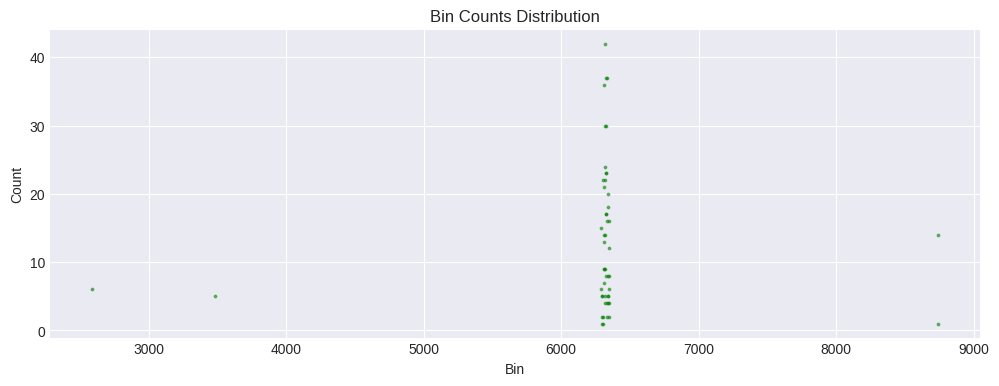

In [229]:
# Plotting
plt.style.use('seaborn-v0_8-darkgrid')  # Example style, replace with your preferred style
fig, ax = plt.subplots(figsize=(12, 4))

# Assuming bin_counts index is what you want on the x-axis and the values are what you want on the y-axis
ax.scatter(bin_counts.index, bin_counts.values, s=3, alpha=0.5, color='green')  # s controls the marker size, alpha controls transparency

ax.set_xlabel('Bin')  # Assuming 'Bin' is the appropriate label
ax.set_ylabel('Count')
ax.set_title('Bin Counts Distribution')

plt.show()